In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pylab import rcParams
from pandas.plotting import autocorrelation_plot

# Datensätze Temperatur und rel. Feuchtigkeit aus csv-Exportdatei einlesen  

## (kein vorheriges Bearbeiten)

In [20]:
def parse_date(x):
    try:
        return pd.to_datetime(x, format='%m/%d/%Y %H:%M:%S')
    except ValueError:
        return pd.to_datetime(x, format='%d/%m/%Y %H:%M:%S')

#Sensordaten Temperatur einlesen 
temperature_data = pd.read_csv(
    'Sensor_Temp_23-04.csv',
    sep='|',
    header=0,
    parse_dates=['Date'],
    date_parser=parse_date
)

temperature_data.rename(columns={'Date': 'Datum', 'Value': 'Innenraum Temperatur'}, inplace=True)


#Sensordaten Feuchtigkeit einlesen 
humidity_data = pd.read_csv(
    'Sensor_Hum_23-04.csv',
    sep='|',
    header=0,
    parse_dates=['Date'],
    date_parser=parse_date
)

humidity_data.rename(columns={'Date': 'Datum', 'Value': 'relative Feuchtigkeit'}, inplace=True)


#-----------------------------------------------------------------------------------------------------


dataset = temperature_data.set_index('Datum').join(humidity_data.set_index('Datum'), how='inner')

print(dataset.head(20))

                     Innenraum Temperatur  relative Feuchtigkeit
Datum                                                           
2024-03-25 00:10:34                  12.2                     54
2024-03-25 00:25:34                  12.2                     55
2024-03-25 00:40:34                  12.1                     55
2024-03-25 00:55:34                  12.1                     55
2024-03-25 01:10:34                  12.1                     55
2024-03-25 01:25:34                  12.0                     55
2024-03-25 01:40:34                  12.0                     55
2024-03-25 01:55:34                  12.0                     55
2024-03-25 02:10:34                  11.9                     55
2024-03-25 02:25:34                  11.9                     55
2024-03-25 02:40:34                  11.9                     55
2024-03-25 02:55:34                  11.8                     55
2024-03-25 03:10:34                  11.8                     55
2024-03-25 03:25:34      

# Mittelwerte pro Tag 

In [24]:
dataset.index = pd.to_datetime(dataset.index)

daily_avg = dataset.resample('D').mean()
daily_avg = daily_avg
daily_avg.head(24)


print(daily_avg.head(20))


            Innenraum Temperatur  relative Feuchtigkeit
Datum                                                  
2024-03-25             12.448958              54.437500
2024-03-26             12.463542              53.781250
2024-03-27             13.917978              53.438202
2024-03-28             14.976042              53.718750
2024-03-29             14.493750              53.395833
2024-03-30             15.451042              54.104167
2024-03-31             17.179167              55.062500
2024-04-01             17.075789              54.442105
2024-04-02             16.333333              53.354167
2024-04-03             15.793750              54.010417
2024-04-04             15.872917              55.729167
2024-04-05             16.280208              56.343750
2024-04-06             17.907292              56.958333
2024-04-07             19.503125              56.125000
2024-04-08             20.158427              56.797753
2024-04-09             21.234375              56

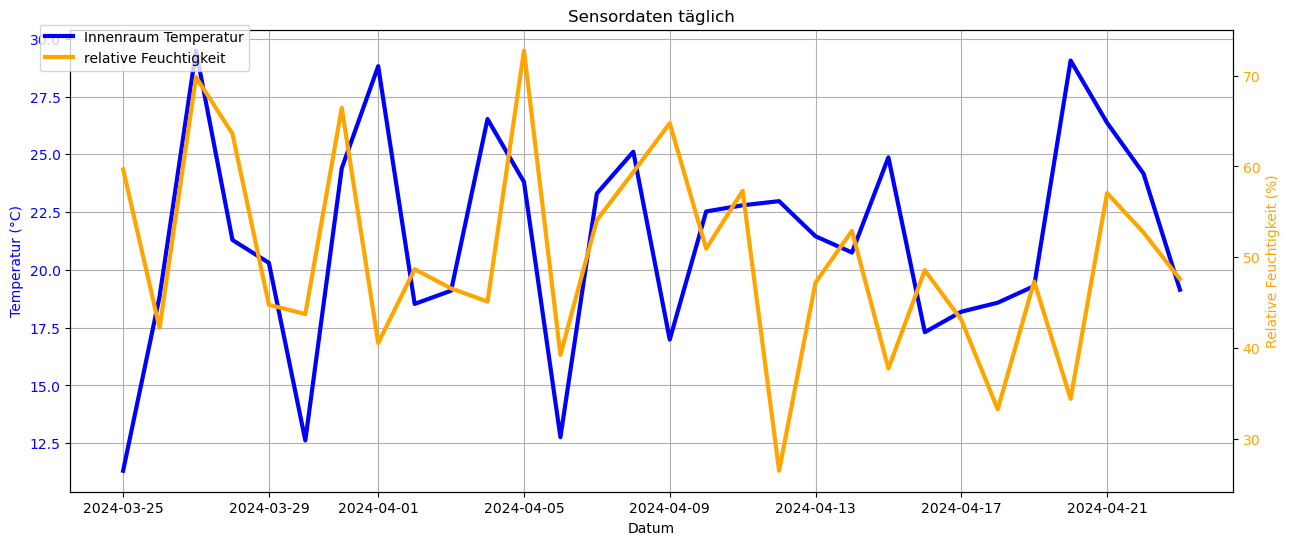

In [44]:
dates = pd.date_range(start='2024-03-25', periods=30, freq='D')
data = {
    'Innenraum Temperatur': np.random.normal(loc=20, scale=5, size=30),
    'relative Feuchtigkeit': np.random.normal(loc=50, scale=10, size=30)
}
daily_avg = pd.DataFrame(data, index=dates)

# Plot erstellen
fig, ax1 = plt.subplots(figsize=(15, 6))

# Temperatur auf der linken y-Achse
ax1.plot(daily_avg.index, daily_avg['Innenraum Temperatur'], linewidth=3, c='blue', label='Innenraum Temperatur')
ax1.set_xlabel('Datum')
ax1.set_ylabel('Temperatur (°C)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# zweite y-Achse für die relative Feuchtigkeit
ax2 = ax1.twinx()
ax2.plot(daily_avg.index, daily_avg['relative Feuchtigkeit'], linewidth=3, c='orange', label='relative Feuchtigkeit')
ax2.set_ylabel('Relative Feuchtigkeit (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Titel und Legenden
plt.title("Sensordaten täglich")
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.show()

In [45]:
#Außentemperatur historisch 
outdoor_data = pd.read_csv(
    'Temp_24.csv',
    sep=',',
    header=0,
    parse_dates=['Datum'],
    date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'),
    index_col='Datum'
)

outdoor_data.rename(columns={'Temp': 'Außentemperatur'}, inplace=True)


print(outdoor_data.head(20))


            Außentemperatur
Datum                      
2024-03-25              5.1
2024-03-26              8.1
2024-03-27             13.0
2024-03-28              9.9
2024-03-29             11.2
2024-03-30             17.0
2024-03-31             15.4
2024-04-01             13.8
2024-04-02             10.7
2024-04-03             11.0
2024-04-04             12.4
2024-04-05             15.5
2024-04-06             18.8
2024-04-07             19.1
2024-04-08             21.0
2024-04-09             18.4
2024-04-10             10.0
2024-04-11             11.6
2024-04-12             14.5
2024-04-13             16.5


In [52]:
# Daten auf gleiche Frequenz bringen (falls notwendig)
outdoor_data_daily = outdoor_data.resample('D').mean()

# Daten zusammenführen
data_sum = daily_avg.join(outdoor_data_daily, how='inner')

# Den Index zurück in eine Spalte konvertieren und dann als Index setzen
data_sum.reset_index(inplace=True)
data_sum.set_index('Datum', inplace=True)

# Überprüfen, ob Daten erfolgreich zusammengeführt wurden
print(data_sum.head(20))


KeyError: "None of ['Datum'] are in the columns"

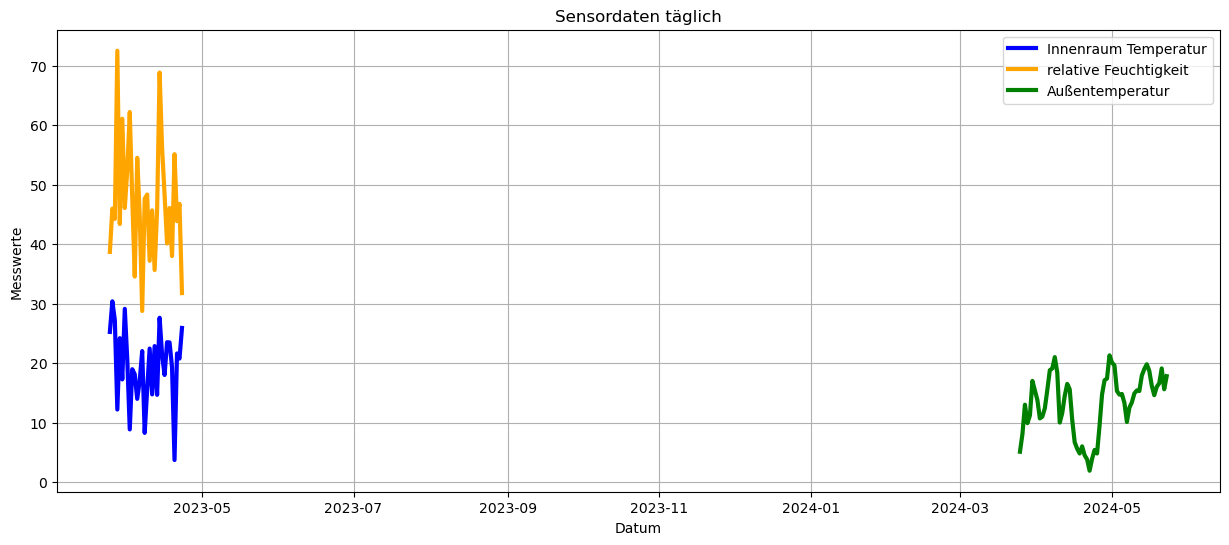

In [39]:
plt.figure(figsize=(15, 6))
plt.plot(daily_avg.index, daily_avg['Innenraum Temperatur'], linewidth=3,c='blue', label='Innenraum Temperatur')
plt.plot(daily_avg.index, daily_avg['relative Feuchtigkeit'], linewidth=3,c='orange', label='relative Feuchtigkeit')
plt.plot(outdoor_data.index, outdoor_data['Außentemperatur'], linewidth=3,c='green', label='Außentemperatur')

plt.title("Sensordaten täglich")
plt.xlabel("Datum")
plt.ylabel("Messwerte")

plt.grid(True)
plt.legend()
plt.show()